# Loading the Dataset

In [16]:
import pandas as pd
import random
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

In [17]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disables auto-optimizations that introduce randomness


def init_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [18]:
set_seed(42)

In [19]:
class EyeDiseaseDataset:
    def __init__(self, dataset_path, img_size=(224, 224), batch_size=32, train_split=0.7, val_split=0.2):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = 1 - (train_split + val_split)

        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Load dataset
        self.dataset = datasets.ImageFolder(root=self.dataset_path, transform=self.transform)
        self.class_names = self.dataset.classes

        # Get class-wise image count
        self.class_counts = self.get_class_distribution()

        # Split dataset
        self.train_dataset, self.val_dataset, self.test_dataset = self.split_dataset()

        print("Training set class distribution:", len(self.train_dataset))
        print("Validation set class distribution:", len(self.val_dataset))
        print("Test set class distribution:", len(self.test_dataset))
       
        # Create dataloaders
        self.train_loader = self.create_dataloader(self.train_dataset, shuffle=True)
        self.val_loader = self.create_dataloader(self.val_dataset, shuffle=False)
        self.test_loader = self.create_dataloader(self.test_dataset, shuffle=False)

    def get_class_distribution(self):
        """ Count number of images per class """
        class_counts = Counter(self.dataset.targets)
        return {self.class_names[i]: class_counts[i] for i in range(len(self.class_names))}
    def split_dataset(self):
        """ Split dataset into train, validation, and test sets """
        targets = self.dataset.targets  # Get class labels
        indices = np.arange(len(targets))  # Generate indices

        # First split: Separate out test data
        train_val_idx, test_idx, train_val_targets, test_targets = train_test_split(
            indices, targets, test_size=self.test_split, stratify=targets, random_state=42
        )

        # Second split: Separate train and validation data
        train_idx, val_idx, _, _ = train_test_split(
            train_val_idx, train_val_targets, 
            test_size=self.val_split / (self.train_split + self.val_split), 
            stratify=train_val_targets, 
            random_state=42
        )

        return Subset(self.dataset, train_idx), Subset(self.dataset, val_idx), Subset(self.dataset, test_idx)    
    def create_dataloader(self, dataset, shuffle):
        """ Create DataLoader from dataset """
        return DataLoader(
            dataset, batch_size=self.batch_size, shuffle=shuffle, 
            num_workers=0, worker_init_fn=lambda _: np.random.seed(42)
        )

    def get_dataloaders(self):
        """ Return train, validation, and test dataloaders """
        return self.train_loader, self.val_loader, self.test_loader

    def get_class_names(self):
        """ Return class names """
        return self.class_names

    def show_dataset_distribution(self):
        """ Print and visualize dataset distribution """
        print("\n📌 **Dataset Distribution:**")
        total_images = sum(self.class_counts.values())
        print(f"Total Images: {total_images}")

        for class_name, count in self.class_counts.items():
            train_count = int(self.train_split * count)
            val_count = int(self.val_split * count)
            test_count = count - train_count - val_count
            print(f"{class_name}: Total={count}, Train={train_count}, Val={val_count}, Test={test_count}")

        # Plot class distribution
        plt.figure(figsize=(10, 5))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Class Names")
        plt.ylabel("Number of Images")
        plt.title("Dataset Class Distribution")
        plt.show()
    def save_class_distribution_csv(self):
        """ Generate a CSV file for dataset class distribution """
        total_images = sum(self.class_counts.values())
        class_data = []

        for class_name, count in self.class_counts.items():
            train_count = int(self.train_split * count)
            val_count = int(self.val_split * count)
            test_count = count - train_count - val_count
            class_data.append([class_name, count, train_count, val_count, test_count])

        df = pd.DataFrame(class_data, columns=["Class Name", "Total Images", "Train Images", "Val Images", "Test Images"])
        df.to_csv("class_distribution.csv", index=False)
        print("\n✅ `class_distribution.csv` file saved successfully!")


In [20]:
dataset_path = "/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset"
dataset = EyeDiseaseDataset(dataset_path)

train_loader, val_loader, test_loader = dataset.get_dataloaders()

Training set class distribution: 11368
Validation set class distribution: 3249
Test set class distribution: 1625


In [21]:
class_labels = dataset.get_class_names()
print("Class Labels:", class_labels)

Class Labels: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']



📌 **Dataset Distribution:**
Total Images: 16242
Central Serous Chorioretinopathy-Color Fundus: Total=606, Train=424, Val=121, Test=61
Diabetic Retinopathy: Total=3444, Train=2410, Val=688, Test=346
Disc Edema: Total=762, Train=533, Val=152, Test=77
Glaucoma: Total=2880, Train=2015, Val=576, Test=289
Healthy: Total=2676, Train=1873, Val=535, Test=268
Macular Scar: Total=1937, Train=1355, Val=387, Test=195
Myopia: Total=2251, Train=1575, Val=450, Test=226
Pterygium: Total=102, Train=71, Val=20, Test=11
Retinal Detachment: Total=750, Train=525, Val=150, Test=75
Retinitis Pigmentosa: Total=834, Train=583, Val=166, Test=85


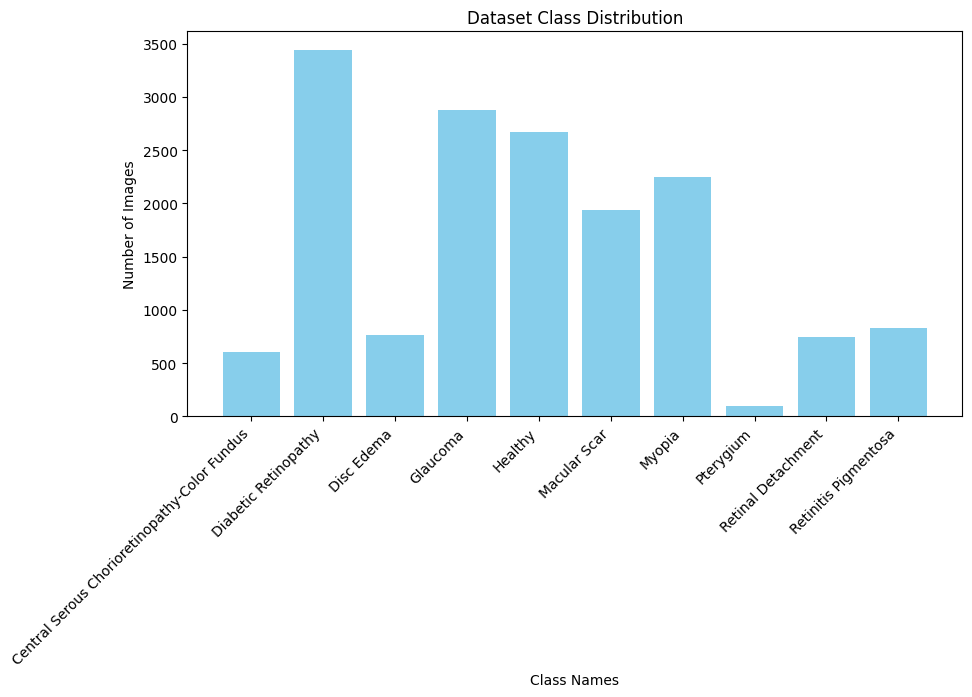

In [22]:
dataset.show_dataset_distribution()

In [23]:
dataset.save_class_distribution_csv()


✅ `class_distribution.csv` file saved successfully!


# Training with Swin Transformer

In [24]:
class SwinTransformerClassifier:
    def __init__(self, num_classes=10, optimizer_name="AdamW", learning_rate=1e-4, weight_decay=1e-4, patience=5, device=None):
        self.num_classes = num_classes
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")

        # Load Pretrained Swin Transformer
        self.model = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)
        
        # Modify Final Layer for num_classes
        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, self.num_classes)
        self.model = self.model.to(self.device)

        # Loss Function
        self.criterion = nn.CrossEntropyLoss()

        # Optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.optimizer = self.get_optimizer(optimizer_name)

        # Learning Rate Scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)

        # Early Stopping
        self.best_val_loss = float('inf')
        self.patience = patience
        self.early_stop_counter = 0

        # TensorBoard Logging
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.writer = SummaryWriter(log_dir=f"runs/swin_transformer_{timestamp}")

        # Store loss & accuracy
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.learning_rates = []

        # Best Model Saving
        self.best_model_path = f"best_swin_model_{timestamp}.pth"

    def get_optimizer(self, optimizer_name):
        optimizers = {
            "AdamW": optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay),
            "Adam": optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay),
            "RMSprop": optim.RMSprop(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay, momentum=0.9)
        }
        return optimizers.get(optimizer_name, optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay))
    
    def train(self, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            train_loss, correct, total = 0, 0, 0
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

            for images, labels in loop:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

            train_acc = 100. * correct / total
            val_loss, val_acc, _, _, _, _ = self.evaluate(val_loader, class_labels=class_labels, print_report=False)

            self.train_losses.append(train_loss / len(train_loader))
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            self.learning_rates.append(self.optimizer.param_groups[0]['lr'])

            self.writer.add_scalar("Loss/Train", self.train_losses[-1], epoch)
            self.writer.add_scalar("Loss/Validation", val_loss, epoch)
            self.writer.add_scalar("Accuracy/Train", train_acc, epoch)
            self.writer.add_scalar("Accuracy/Validation", val_acc, epoch)
            self.writer.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            self.scheduler.step(val_loss)

            print(f"Epoch {epoch+1}: Train Loss={self.train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.early_stop_counter = 0
                torch.save(self.model.state_dict(), self.best_model_path)
                print("✅ Best model saved!")
            else:
                self.early_stop_counter += 1
                if self.early_stop_counter >= self.patience:
                    print("⏹️ Early stopping triggered!")
                    break
    
    def evaluate(self, val_loader, class_labels, print_report=True):
        self.model.eval()
        correct, total, val_loss = 0, 0, 0
        all_preds, all_labels = [], []
        class_correct = [0] * self.num_classes
        class_total = [0] * self.num_classes
        misclassified_samples = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                for img, pred, true in zip(images.cpu(), predicted.cpu(), labels.cpu()):
                    if pred != true:
                        misclassified_samples.append((img, class_labels[true], class_labels[pred]))
                
                for i in range(len(labels)):
                    label = labels[i].item()
                    class_total[label] += 1
                    if predicted[i].item() == label:
                        class_correct[label] += 1
        # Compute Metrics
        accuracy = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
        
        # Per-Class Accuracy
        class_accuracies = {class_labels[i]: (100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0) for i in range(self.num_classes)}
        
        pred_counts = Counter(all_preds)
        if print_report:
            print("📊 Classification Report:\n", classification_report(
                all_labels, 
                all_preds, 
                labels=list(range(len(class_labels))), 
                target_names=class_labels, 
                zero_division=0  
            ))

            cm = confusion_matrix(all_labels, all_preds)
        
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title("Confusion Matrix")
            plt.show()

            print("📌 Per-Class Accuracy:")
            for cls, acc in class_accuracies.items():
                print(f"{cls}: {acc:.2f}%")
    
        return val_loss / len(val_loader), accuracy, precision, recall, f1, misclassified_samples
    def test(self, test_loader, class_labels):
        print("🚀 Evaluating on Test Set...")
        _, test_acc, test_precision, test_recall, test_f1, _ = self.evaluate(test_loader, class_labels=class_labels)
        print(f"Test Accuracy: {test_acc:.2f}%, Precision: {test_precision:.2f}%, Recall: {test_recall:.2f}%, F1-score: {test_f1:.2f}%")

    def load_best_model(self):
        print("🔄 Loading best model...")
        self.model.load_state_dict(torch.load(self.best_model_path))
        self.model.to(self.device)
    
    def hyperparameter_search(self, train_loader, val_loader, class_labels,
                              optimizers=["AdamW", "RMSprop", "Adam"],
                              learning_rates=[1e-3, 1e-5],
                              weight_decays=[1e-6, 1e-3],
                              epochs=10):
        best_accuracy = 0
        best_params = None
        
        for opt in optimizers:
            for lr in learning_rates:
                for wd in weight_decays:
                    print(f"\n🔍 Training with Optimizer: {opt}, Learning Rate: {lr}, Weight Decay: {wd}")
                    classifier = SwinTransformerClassifier(num_classes=self.num_classes, optimizer_name=opt, learning_rate=lr, weight_decay=wd, device=self.device)
                    classifier.train(train_loader, val_loader, num_epochs=epochs)
                    _, val_acc, _, _, _, _ = classifier.evaluate(val_loader, class_labels=class_labels, print_report=False)
                    if val_acc > best_accuracy:
                        best_accuracy = val_acc
                        best_params = (opt, lr, wd)
        print(f"\n🏆 Best Hyperparameters: {best_params} with Accuracy: {best_accuracy:.2f}%")
    def plot_loss_curve(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

    def plot_accuracy_curve(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy Curve')
        plt.legend()
        plt.show()

    def plot_learning_rate_curve(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.learning_rates, label='Learning Rate', color='r')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Decay')
        plt.legend()
        plt.show()


In [16]:
find_param = SwinTransformerClassifier(num_classes=10)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
find_param.hyperparameter_search(train_loader, val_loader, class_labels, optimizers=["AdamW"], epochs=2)


🔍 Training with Optimizer: AdamW, Learning Rate: 0.001, Weight Decay: 1e-06


Epoch 1/2: 100%|██████████| 356/356 [08:59<00:00,  1.52s/it, acc=18.7, loss=2.21]


Epoch 1: Train Loss=2.1091, Val Loss=2.0789, Val Acc=21.21%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [08:00<00:00,  1.35s/it, acc=20.5, loss=2.32]


Epoch 2: Train Loss=2.0730, Val Loss=2.0592, Val Acc=21.21%
✅ Best model saved!

🔍 Training with Optimizer: AdamW, Learning Rate: 0.001, Weight Decay: 0.001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:53<00:00,  1.33s/it, acc=19.6, loss=2.22]


Epoch 1: Train Loss=2.0979, Val Loss=2.0688, Val Acc=17.73%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:50<00:00,  1.32s/it, acc=20.1, loss=2.33]


Epoch 2: Train Loss=2.0733, Val Loss=2.0570, Val Acc=21.21%
✅ Best model saved!

🔍 Training with Optimizer: AdamW, Learning Rate: 1e-05, Weight Decay: 1e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:48<00:00,  1.32s/it, acc=54.5, loss=0.913]


Epoch 1: Train Loss=1.3114, Val Loss=0.6975, Val Acc=74.52%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:50<00:00,  1.32s/it, acc=74.7, loss=0.102]


Epoch 2: Train Loss=0.7113, Val Loss=0.5227, Val Acc=80.09%
✅ Best model saved!

🔍 Training with Optimizer: AdamW, Learning Rate: 1e-05, Weight Decay: 0.001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:59<00:00,  1.35s/it, acc=58.2, loss=0.466]


Epoch 1: Train Loss=1.2118, Val Loss=0.6438, Val Acc=76.55%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [08:00<00:00,  1.35s/it, acc=75.9, loss=0.343]


Epoch 2: Train Loss=0.6790, Val Loss=0.5121, Val Acc=81.29%
✅ Best model saved!

🏆 Best Hyperparameters: ('AdamW', 1e-05, 0.001) with Accuracy: 81.29%


In [18]:
find_param.hyperparameter_search(train_loader, val_loader, class_labels, optimizers=["RMSprop"], epochs=2)


🔍 Training with Optimizer: RMSprop, Learning Rate: 0.001, Weight Decay: 1e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:50<00:00,  1.32s/it, acc=16.3, loss=2.41]


Epoch 1: Train Loss=4.7100, Val Loss=2.4305, Val Acc=5.14%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:44<00:00,  1.31s/it, acc=17.8, loss=2.03]


Epoch 2: Train Loss=2.2827, Val Loss=2.1290, Val Acc=21.21%
✅ Best model saved!

🔍 Training with Optimizer: RMSprop, Learning Rate: 0.001, Weight Decay: 0.001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:43<00:00,  1.30s/it, acc=15.9, loss=2.51]


Epoch 1: Train Loss=5.3345, Val Loss=2.1395, Val Acc=21.21%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:44<00:00,  1.30s/it, acc=18.6, loss=1.82]


Epoch 2: Train Loss=2.1831, Val Loss=2.0683, Val Acc=21.21%
✅ Best model saved!

🔍 Training with Optimizer: RMSprop, Learning Rate: 1e-05, Weight Decay: 1e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:47<00:00,  1.31s/it, acc=70.1, loss=0.599]


Epoch 1: Train Loss=0.8305, Val Loss=0.5552, Val Acc=79.99%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:45<00:00,  1.31s/it, acc=82.2, loss=0.748]


Epoch 2: Train Loss=0.4776, Val Loss=0.4350, Val Acc=82.36%
✅ Best model saved!

🔍 Training with Optimizer: RMSprop, Learning Rate: 1e-05, Weight Decay: 0.001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:50<00:00,  1.32s/it, acc=68.6, loss=0.68] 


Epoch 1: Train Loss=0.8738, Val Loss=0.5474, Val Acc=78.67%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:50<00:00,  1.32s/it, acc=81.3, loss=0.696]


Epoch 2: Train Loss=0.5060, Val Loss=0.4750, Val Acc=81.26%
✅ Best model saved!

🏆 Best Hyperparameters: ('RMSprop', 1e-05, 1e-06) with Accuracy: 82.36%


In [19]:
find_param.hyperparameter_search(train_loader, val_loader, class_labels, optimizers=["Adam"], epochs=2)


🔍 Training with Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 1e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:43<00:00,  1.30s/it, acc=19.7, loss=1.6] 


Epoch 1: Train Loss=2.0971, Val Loss=2.0866, Val Acc=17.73%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:42<00:00,  1.30s/it, acc=20.2, loss=1.79]


Epoch 2: Train Loss=2.0698, Val Loss=2.0568, Val Acc=21.21%
✅ Best model saved!

🔍 Training with Optimizer: Adam, Learning Rate: 0.001, Weight Decay: 0.001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:49<00:00,  1.32s/it, acc=21.3, loss=2.35]


Epoch 1: Train Loss=2.0597, Val Loss=2.0230, Val Acc=25.08%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:45<00:00,  1.31s/it, acc=22.7, loss=1.8] 


Epoch 2: Train Loss=2.0316, Val Loss=2.0273, Val Acc=20.68%

🔍 Training with Optimizer: Adam, Learning Rate: 1e-05, Weight Decay: 1e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:38<00:00,  1.29s/it, acc=54, loss=0.667]  


Epoch 1: Train Loss=1.3321, Val Loss=0.7732, Val Acc=71.68%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:38<00:00,  1.29s/it, acc=74.6, loss=0.773]


Epoch 2: Train Loss=0.7188, Val Loss=0.5178, Val Acc=79.78%
✅ Best model saved!

🔍 Training with Optimizer: Adam, Learning Rate: 1e-05, Weight Decay: 0.001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/2: 100%|██████████| 356/356 [07:50<00:00,  1.32s/it, acc=55.3, loss=1.01] 


Epoch 1: Train Loss=1.2770, Val Loss=0.7225, Val Acc=72.42%
✅ Best model saved!


Epoch 2/2: 100%|██████████| 356/356 [07:50<00:00,  1.32s/it, acc=74.1, loss=0.911]


Epoch 2: Train Loss=0.7319, Val Loss=0.5205, Val Acc=80.61%
✅ Best model saved!

🏆 Best Hyperparameters: ('Adam', 1e-05, 0.001) with Accuracy: 80.61%


## Training with Best Parameter

In [11]:
num_classes=10
optimizer_name='RMSprop'
learning_rate=1e-05
weight_decay=1e-06
patience=10

In [12]:
classifier = SwinTransformerClassifier(
                num_classes=10, 
                optimizer_name=optimizer_name,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                patience=patience
            )


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 213MB/s]  
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
classifier.train(train_loader, val_loader, num_epochs=50)

Epoch 1/50: 100%|██████████| 356/356 [11:22<00:00,  1.92s/it, acc=68.9, loss=1.01] 


Epoch 1: Train Loss=0.8824, Val Loss=0.4868, Val Acc=81.87%
✅ Best model saved!


Epoch 2/50: 100%|██████████| 356/356 [09:45<00:00,  1.65s/it, acc=82.1, loss=0.74] 


Epoch 2: Train Loss=0.4894, Val Loss=0.4472, Val Acc=81.75%
✅ Best model saved!


Epoch 3/50: 100%|██████████| 356/356 [09:47<00:00,  1.65s/it, acc=85.5, loss=0.726]


Epoch 3: Train Loss=0.3849, Val Loss=0.4074, Val Acc=84.06%
✅ Best model saved!


Epoch 4/50: 100%|██████████| 356/356 [09:45<00:00,  1.64s/it, acc=88.2, loss=0.26]  


Epoch 4: Train Loss=0.3120, Val Loss=0.3737, Val Acc=85.07%
✅ Best model saved!


Epoch 5/50: 100%|██████████| 356/356 [09:47<00:00,  1.65s/it, acc=90.3, loss=0.175] 


Epoch 5: Train Loss=0.2612, Val Loss=0.4021, Val Acc=84.36%


Epoch 6/50: 100%|██████████| 356/356 [09:55<00:00,  1.67s/it, acc=91.2, loss=0.109] 


Epoch 6: Train Loss=0.2427, Val Loss=0.3982, Val Acc=85.26%


Epoch 7/50: 100%|██████████| 356/356 [10:00<00:00,  1.69s/it, acc=92.1, loss=0.0629]


Epoch 7: Train Loss=0.2066, Val Loss=0.4407, Val Acc=85.47%


Epoch 8/50: 100%|██████████| 356/356 [09:50<00:00,  1.66s/it, acc=92.5, loss=0.0596]


Epoch 8: Train Loss=0.1927, Val Loss=0.4755, Val Acc=85.01%


Epoch 9/50: 100%|██████████| 356/356 [09:36<00:00,  1.62s/it, acc=94.6, loss=0.428]  


Epoch 9: Train Loss=0.1273, Val Loss=0.4048, Val Acc=86.67%


Epoch 10/50: 100%|██████████| 356/356 [09:29<00:00,  1.60s/it, acc=94.9, loss=0.0806] 


Epoch 10: Train Loss=0.1068, Val Loss=0.4206, Val Acc=86.61%


Epoch 11/50: 100%|██████████| 356/356 [09:21<00:00,  1.58s/it, acc=95.4, loss=0.344]  


Epoch 11: Train Loss=0.0994, Val Loss=0.4244, Val Acc=86.70%


Epoch 12/50: 100%|██████████| 356/356 [09:44<00:00,  1.64s/it, acc=95.1, loss=0.0829] 


Epoch 12: Train Loss=0.0983, Val Loss=0.4387, Val Acc=86.70%


Epoch 13/50: 100%|██████████| 356/356 [09:50<00:00,  1.66s/it, acc=95.9, loss=0.0328] 


Epoch 13: Train Loss=0.0828, Val Loss=0.4520, Val Acc=86.67%


Epoch 14/50:  76%|███████▌  | 271/356 [07:19<02:17,  1.62s/it, acc=95.7, loss=0.129]  

In [25]:
num_classes=10
optimizer_name='RMSprop'
learning_rate=1e-05
weight_decay=1e-06
patience=5

In [26]:
classifier = SwinTransformerClassifier(
                num_classes=10, 
                optimizer_name=optimizer_name,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                patience=patience
            )

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [27]:
classifier.train(train_loader, val_loader, num_epochs=20)

Epoch 1/20: 100%|██████████| 356/356 [08:06<00:00,  1.37s/it, acc=68.9, loss=1.01] 


Epoch 1: Train Loss=0.8824, Val Loss=0.4868, Val Acc=81.87%
✅ Best model saved!


Epoch 2/20: 100%|██████████| 356/356 [08:00<00:00,  1.35s/it, acc=82.1, loss=0.74] 


Epoch 2: Train Loss=0.4894, Val Loss=0.4472, Val Acc=81.75%
✅ Best model saved!


Epoch 3/20: 100%|██████████| 356/356 [08:09<00:00,  1.37s/it, acc=85.5, loss=0.726]


Epoch 3: Train Loss=0.3849, Val Loss=0.4074, Val Acc=84.06%
✅ Best model saved!


Epoch 4/20: 100%|██████████| 356/356 [08:13<00:00,  1.39s/it, acc=88.2, loss=0.26]  


Epoch 4: Train Loss=0.3120, Val Loss=0.3737, Val Acc=85.07%
✅ Best model saved!


Epoch 5/20: 100%|██████████| 356/356 [08:12<00:00,  1.38s/it, acc=90.3, loss=0.175] 


Epoch 5: Train Loss=0.2612, Val Loss=0.4021, Val Acc=84.36%


Epoch 6/20: 100%|██████████| 356/356 [08:10<00:00,  1.38s/it, acc=91.2, loss=0.109] 


Epoch 6: Train Loss=0.2427, Val Loss=0.3982, Val Acc=85.26%


Epoch 7/20: 100%|██████████| 356/356 [08:06<00:00,  1.37s/it, acc=92.1, loss=0.0629]


Epoch 7: Train Loss=0.2066, Val Loss=0.4407, Val Acc=85.47%


Epoch 8/20: 100%|██████████| 356/356 [08:37<00:00,  1.45s/it, acc=92.5, loss=0.0596]


Epoch 8: Train Loss=0.1927, Val Loss=0.4755, Val Acc=85.01%


Epoch 9/20: 100%|██████████| 356/356 [08:24<00:00,  1.42s/it, acc=94.6, loss=0.428]  


Epoch 9: Train Loss=0.1273, Val Loss=0.4048, Val Acc=86.67%
⏹️ Early stopping triggered!


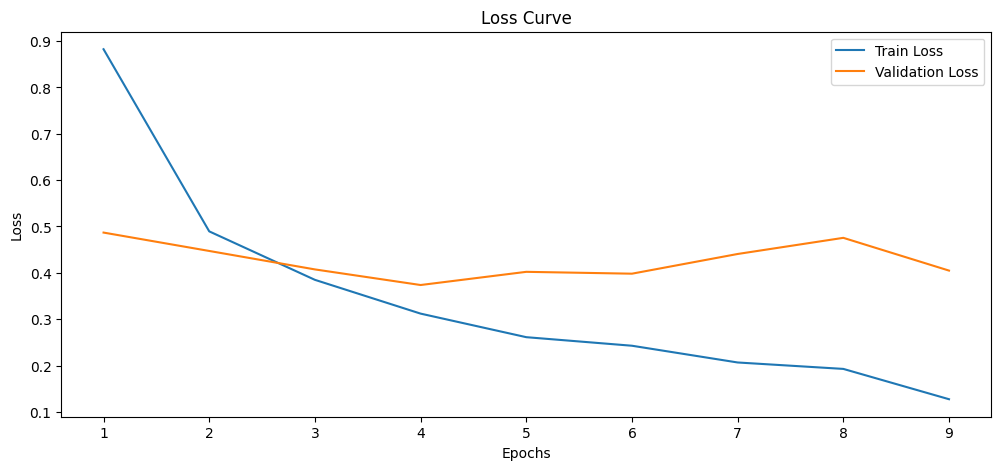

In [28]:
classifier.plot_loss_curve()

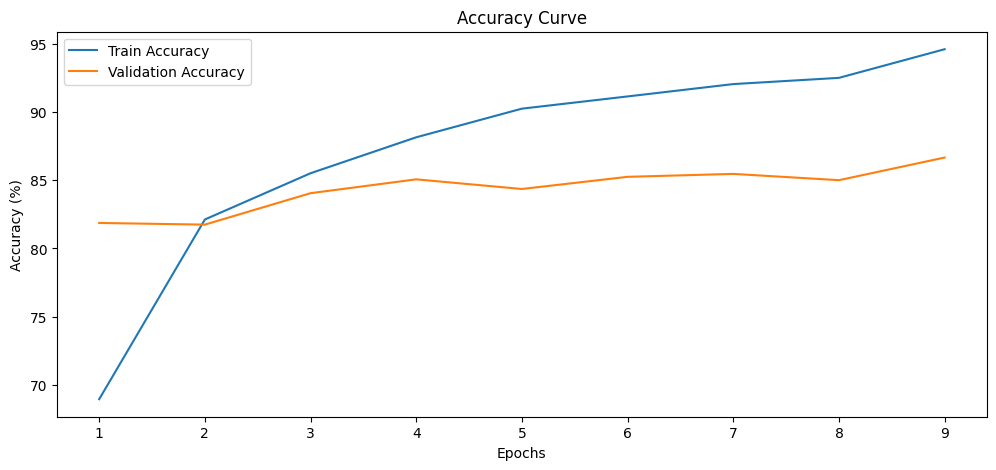

In [29]:
classifier.plot_accuracy_curve()

In [30]:
state_dict = torch.load(classifier.best_model_path, weights_only=True)
classifier.model.load_state_dict(state_dict)

<All keys matched successfully>

📊 Classification Report:
                                                precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.84      0.97      0.90       424
                         Diabetic Retinopathy       0.98      0.98      0.98      2410
                                   Disc Edema       0.99      0.95      0.97       533
                                     Glaucoma       0.82      0.91      0.86      2016
                                      Healthy       0.97      0.80      0.88      1873
                                 Macular Scar       0.96      0.86      0.91      1356
                                       Myopia       0.85      0.97      0.91      1576
                                    Pterygium       1.00      1.00      1.00        71
                           Retinal Detachment       0.99      1.00      1.00       525
                         Retinitis Pigmentosa       0.99      0.94      0.96       584

               

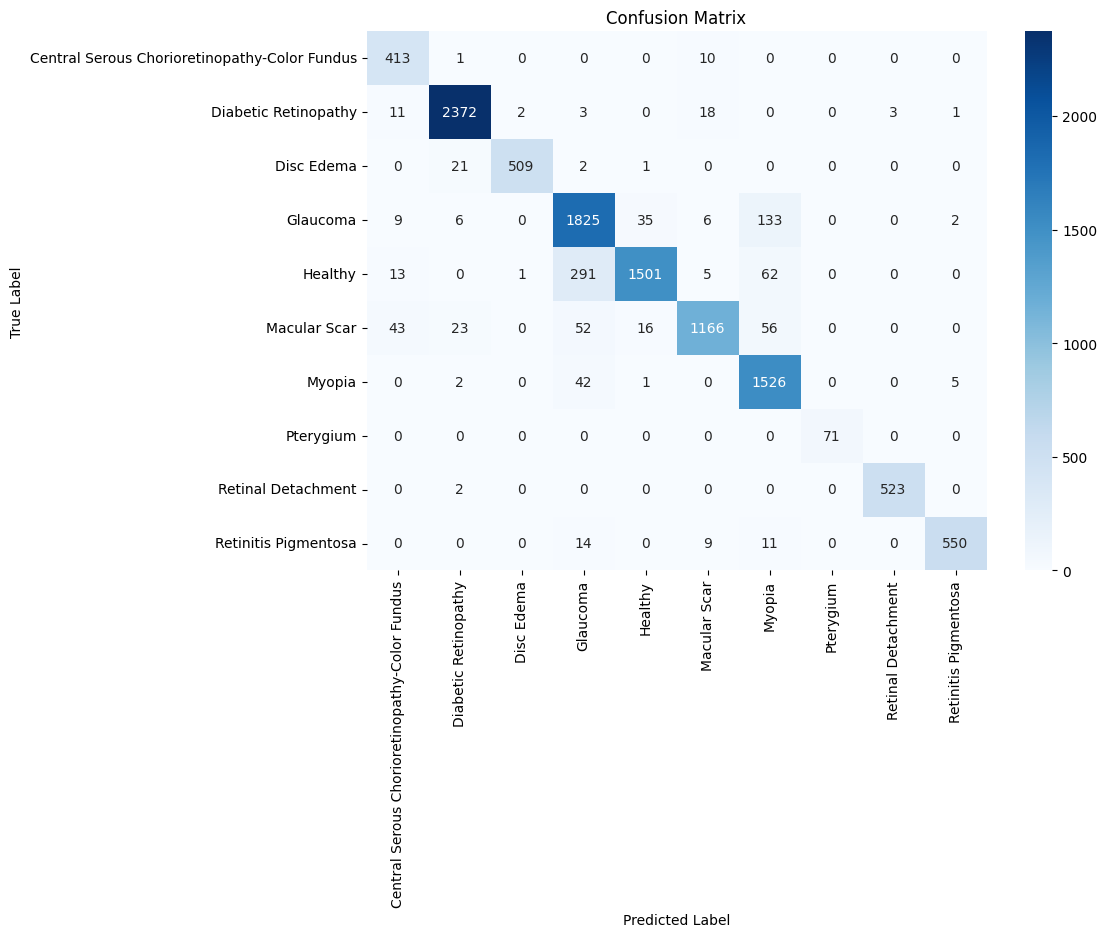

📌 Per-Class Accuracy:
Central Serous Chorioretinopathy-Color Fundus: 97.41%
Diabetic Retinopathy: 98.42%
Disc Edema: 95.50%
Glaucoma: 90.53%
Healthy: 80.14%
Macular Scar: 85.99%
Myopia: 96.83%
Pterygium: 100.00%
Retinal Detachment: 99.62%
Retinitis Pigmentosa: 94.18%


(0.2139545286157995,
 91.97748064743139,
 92.53319636054015,
 91.97748064743139,
 91.98554307643111,
 [(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-1.0000, -1.0000, -0.9922,  ..., -0.9843, -0.9843, -0.9843],
            [-1.0000, -1.0000, -0.9922,  ..., -0.9843, -0.9843, -0.9843],
            [-1.0000, -1.0000, -0.9922,  ..., -0.9843, -0.9843, -0.9843]],
   
           [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -0.9922,  ..., 

In [31]:
## Training Report
classifier.evaluate(train_loader,class_labels)

🚀 Evaluating on Test Set...
📊 Classification Report:
                                                precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.84      0.97      0.90       424
                         Diabetic Retinopathy       0.98      0.98      0.98      2410
                                   Disc Edema       0.99      0.95      0.97       533
                                     Glaucoma       0.82      0.91      0.86      2016
                                      Healthy       0.97      0.80      0.88      1873
                                 Macular Scar       0.96      0.86      0.91      1356
                                       Myopia       0.85      0.97      0.91      1576
                                    Pterygium       1.00      1.00      1.00        71
                           Retinal Detachment       0.99      1.00      1.00       525
                         Retinitis Pigmentosa       0.99      0.94      0.9

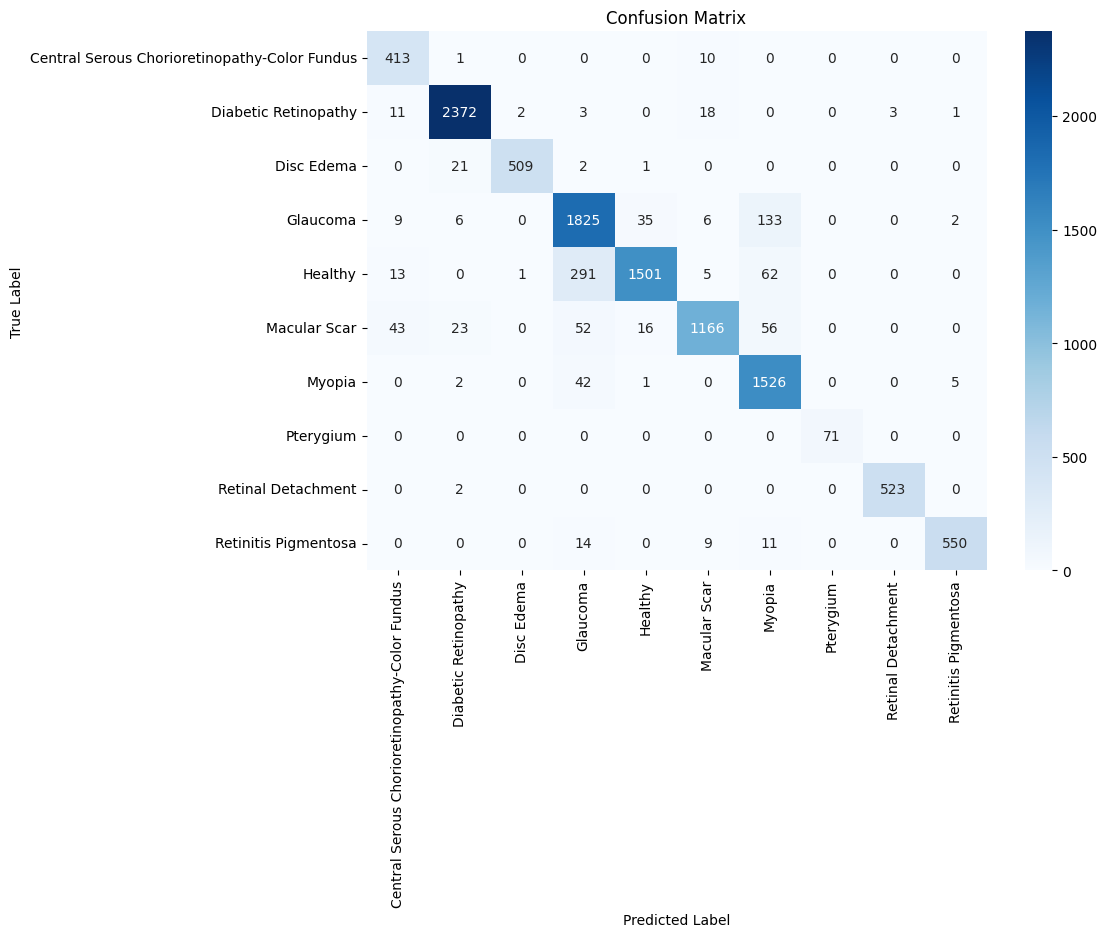

📌 Per-Class Accuracy:
Central Serous Chorioretinopathy-Color Fundus: 97.41%
Diabetic Retinopathy: 98.42%
Disc Edema: 95.50%
Glaucoma: 90.53%
Healthy: 80.14%
Macular Scar: 85.99%
Myopia: 96.83%
Pterygium: 100.00%
Retinal Detachment: 99.62%
Retinitis Pigmentosa: 94.18%
Test Accuracy: 91.98%, Precision: 92.53%, Recall: 91.98%, F1-score: 91.99%


In [34]:
classifier.test(train_loader,class_labels)

📊 Classification Report:
                                                precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.75      0.93      0.83       121
                         Diabetic Retinopathy       0.95      0.97      0.96       689
                                   Disc Edema       0.98      0.90      0.94       153
                                     Glaucoma       0.70      0.78      0.74       576
                                      Healthy       0.88      0.69      0.78       535
                                 Macular Scar       0.88      0.76      0.82       387
                                       Myopia       0.78      0.90      0.84       450
                                    Pterygium       1.00      1.00      1.00        21
                           Retinal Detachment       0.97      0.99      0.98       150
                         Retinitis Pigmentosa       0.95      0.93      0.94       167

               

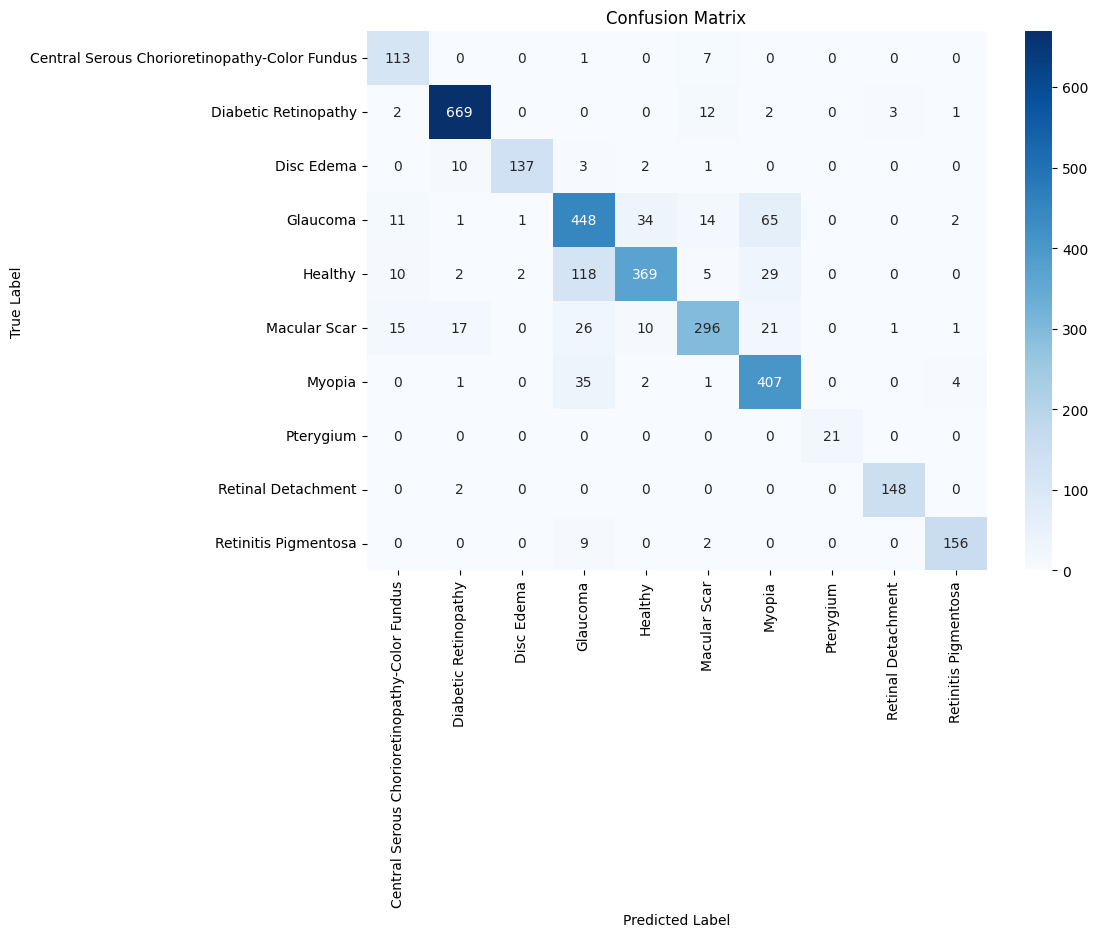

📌 Per-Class Accuracy:
Central Serous Chorioretinopathy-Color Fundus: 93.39%
Diabetic Retinopathy: 97.10%
Disc Edema: 89.54%
Glaucoma: 77.78%
Healthy: 68.97%
Macular Scar: 76.49%
Myopia: 90.44%
Pterygium: 100.00%
Retinal Detachment: 98.67%
Retinitis Pigmentosa: 93.41%


(0.373706614050795,
 85.07232994767621,
 85.80609135814726,
 85.07232994767621,
 85.04274191935397,
 [(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            ...,
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.]],
   
           [[-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            ...,
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.]],
   
           [[-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., -1., -1.],
            ...,
            [-1., -1., -1.,  ..., -1., -1., -1.],
            [-1., -1., -1.,  ..., -1., 

In [32]:
## Validation Report
classifier.evaluate(val_loader,class_labels)

🚀 Evaluating on Test Set...
📊 Classification Report:
                                                precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.75      0.93      0.83       121
                         Diabetic Retinopathy       0.95      0.97      0.96       689
                                   Disc Edema       0.98      0.90      0.94       153
                                     Glaucoma       0.70      0.78      0.74       576
                                      Healthy       0.88      0.69      0.78       535
                                 Macular Scar       0.88      0.76      0.82       387
                                       Myopia       0.78      0.90      0.84       450
                                    Pterygium       1.00      1.00      1.00        21
                           Retinal Detachment       0.97      0.99      0.98       150
                         Retinitis Pigmentosa       0.95      0.93      0.9

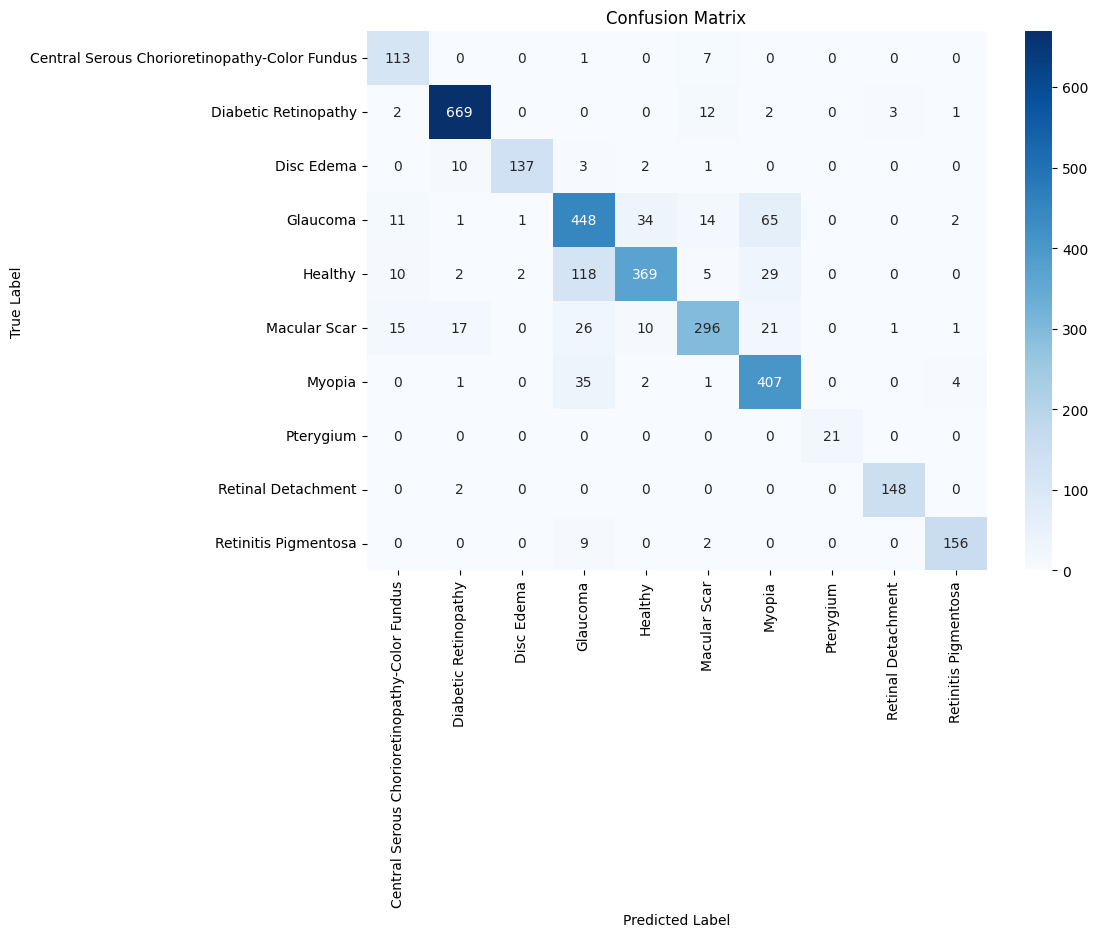

📌 Per-Class Accuracy:
Central Serous Chorioretinopathy-Color Fundus: 93.39%
Diabetic Retinopathy: 97.10%
Disc Edema: 89.54%
Glaucoma: 77.78%
Healthy: 68.97%
Macular Scar: 76.49%
Myopia: 90.44%
Pterygium: 100.00%
Retinal Detachment: 98.67%
Retinitis Pigmentosa: 93.41%
Test Accuracy: 85.07%, Precision: 85.81%, Recall: 85.07%, F1-score: 85.04%


In [35]:
## Validation Report
classifier.test(val_loader,class_labels)

🚀 Evaluating on Test Set...
📊 Classification Report:
                                                precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.76      0.89      0.82        61
                         Diabetic Retinopathy       0.98      0.94      0.96       345
                                   Disc Edema       0.95      0.92      0.93        76
                                     Glaucoma       0.68      0.80      0.74       288
                                      Healthy       0.89      0.67      0.76       268
                                 Macular Scar       0.85      0.75      0.80       194
                                       Myopia       0.76      0.91      0.82       225
                                    Pterygium       1.00      1.00      1.00        10
                           Retinal Detachment       0.96      1.00      0.98        75
                         Retinitis Pigmentosa       0.97      0.93      0.9

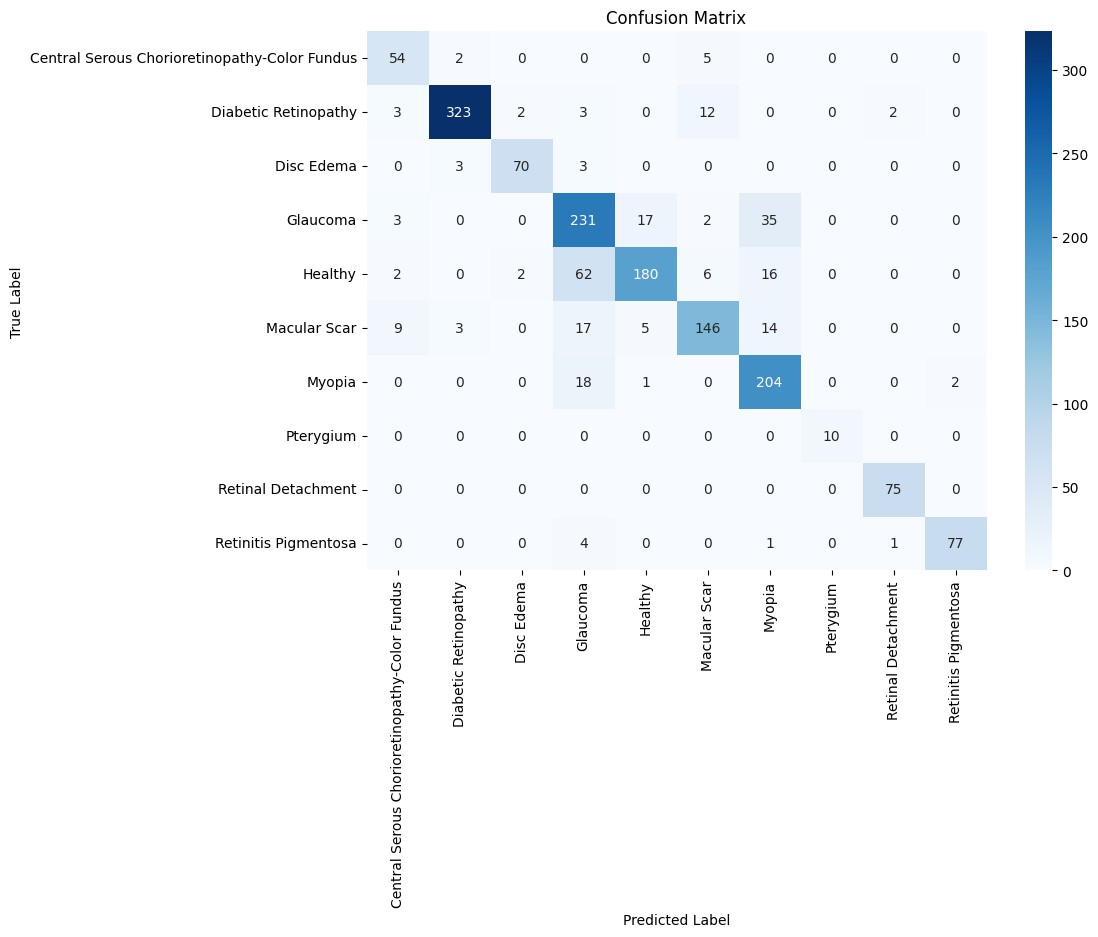

📌 Per-Class Accuracy:
Central Serous Chorioretinopathy-Color Fundus: 88.52%
Diabetic Retinopathy: 93.62%
Disc Edema: 92.11%
Glaucoma: 80.21%
Healthy: 67.16%
Macular Scar: 75.26%
Myopia: 90.67%
Pterygium: 100.00%
Retinal Detachment: 100.00%
Retinitis Pigmentosa: 92.77%
Test Accuracy: 84.31%, Precision: 85.42%, Recall: 84.31%, F1-score: 84.37%


In [33]:
# Test Report
classifier.test(test_loader, class_labels)

# Applying XAI

In [36]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [37]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        self.target_layer = target_layer

        # Hook to capture feature maps (forward hook)
        def forward_hook(module, input, output):
            self.activations = output  # Store feature maps
        
        # Hook to capture gradients (backward hook)
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Store gradients

        # Register the hooks
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, image, class_idx=None):
        image = image.unsqueeze(0).to(next(self.model.parameters()).device)
        self.model.zero_grad()

        # Forward pass
        output = self.model(image)
        
        # If class index is not provided, take the highest probability class
        if class_idx is None:
            class_idx = output.argmax().item()

        # Compute gradients w.r.t the target class
        score = output[0, class_idx]
        score.backward()

        # Get the gradients and feature maps
        gradients = self.gradients.cpu().data.numpy()
        feature_maps = self.activations.cpu().data.numpy()[0]  # Corrected

        # Compute weighted sum of feature maps using gradients
        weights = np.mean(gradients, axis=(1, 2))  # Global Average Pooling
        cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * feature_maps[i]

        # Normalize the CAM
        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (224, 224))  # Resize to image size
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

    def overlay_heatmap(self, original_image, cam, alpha=0.4):
        # Ensure image is in the correct format
        if isinstance(original_image, Image.Image):  # If it's a PIL image, convert to numpy
            original_image = np.array(original_image)
    
        # Resize CAM to match the original image size
        cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    
        # Normalize heatmap
        cam_resized = (cam_resized * 255).astype(np.uint8)
    
        # Convert grayscale heatmap to color
        heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    
        # Convert original image to BGR format if it's in RGB
        if original_image.shape[-1] == 3:  # Check if it's already RGB
            original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
        else:
            original_image_bgr = original_image
    
        # Overlay heatmap onto original image
        overlay = cv2.addWeighted(original_image_bgr, 1 - alpha, heatmap, alpha, 0)
    
        # Convert back to RGB for displaying
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
        return overlay_rgb


# Function to process image and apply Grad-CAM
def apply_gradcam(model, image_path, class_names):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = transform(Image.open(image_path).convert("RGB"))
    original_image = np.array(Image.open(image_path).convert("RGB"))

    # Choose the target layer (last convolutional layer)
    target_layer = model.model.layer4[-1]  # Last conv layer in ResNet50

    # Apply Grad-CAM
    grad_cam = GradCAM(model.model, target_layer)  # Pass model.model
    cam = grad_cam.generate_cam(image)

    # Overlay heatmap
    result = grad_cam.overlay_heatmap(original_image, cam)

    # Show images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(f"Grad-CAM Heatmap")
    plt.axis("off")

    plt.show()

In [ ]:
state_dict = torch.load(classifier.best_model_path, weights_only=True)
classifier.model.load_state_dict(state_dict)
apply_gradcam(classifier, "/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset/Diabetic Retinopathy/DR1.jpg", class_names=class_labels)


In [38]:
apply_gradcam(
    classifier,
    "/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset/Diabetic Retinopathy/DR1021.jpg",
    class_names=class_labels
)

AttributeError: 'SwinTransformer' object has no attribute 'layer4'

In [40]:
apply_gradcam(
    classifier,
    "/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset/Diabetic Retinopathy/DR1051.jpg",
    class_names=class_labels
)

AttributeError: 'SwinTransformer' object has no attribute 'layer4'

In [39]:
def plot_misclassified_samples(misclassified_samples, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Misclassified Samples", fontsize=16)

    for i, (img, true_label, pred_label) in enumerate(misclassified_samples[:num_samples]):
        ax = axes[i // 5, i % 5]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [41]:
import os
import torchvision.transforms as transforms
from PIL import Image

def save_misclassified_samples(misclassified_samples, save_dir):
    """
    Save misclassified images in a structured directory.
    
    Parameters:
        misclassified_samples (list): List of (image, true_label, predicted_label)
        save_dir (str): Root directory to save misclassified samples.
    """
    os.makedirs(save_dir, exist_ok=True)

    transform = transforms.ToPILImage()  # Convert tensor to PIL Image

    for idx, (img, true_label, pred_label) in enumerate(misclassified_samples):
        subdir = os.path.join(save_dir, f"{true_label}_as_{pred_label}")
        os.makedirs(subdir, exist_ok=True)

        image_path = os.path.join(subdir, f"image_{idx}.jpg")
        img = transform(img)  # Convert tensor to PIL Image
        img.save(image_path)

    print(f"✅ Misclassified samples saved in '{save_dir}' directory.")

In [42]:
_, _, _, _, _, misclassified_samples = classifier.evaluate(val_loader,class_labels, print_report=False)

In [43]:
print(len(misclassified_samples))

485


In [44]:
dir = "/kaggle/working/val_mismatch"

In [45]:
save_misclassified_samples(misclassified_samples,dir)

✅ Misclassified samples saved in '/kaggle/working/val_mismatch' directory.


In [46]:
import shutil

zip_name = "val_misclassified_samples.zip"

# Zip the folder
shutil.make_archive(zip_name.replace(".zip", ""), 'zip', dir)

print(f"✅ Folder '{dir}' has been zipped as '{zip_name}'")

✅ Folder '/kaggle/working/val_mismatch' has been zipped as 'val_misclassified_samples.zip'


In [47]:
from IPython.display import FileLink

# Create a download link
FileLink(zip_name)

/kaggle/working/val_misclassified_samples.zip

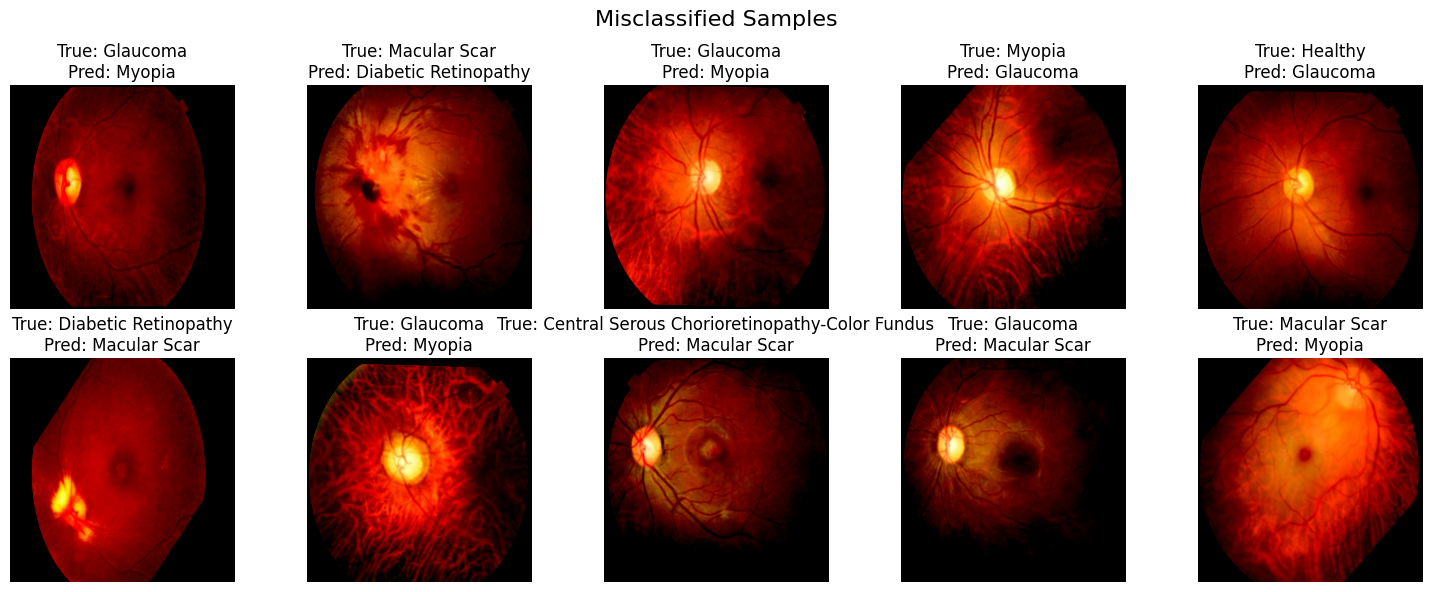

In [48]:
plot_misclassified_samples(misclassified_samples)

In [49]:
_, _, _, _, _, test_misclassified_samples = classifier.evaluate(test_loader,class_labels, print_report=False)

In [50]:
print(len(test_misclassified_samples))

255


In [51]:
test_dir = "/kaggle/working/test_mismatch"

In [52]:
save_misclassified_samples(test_misclassified_samples,test_dir)

✅ Misclassified samples saved in '/kaggle/working/test_mismatch' directory.


In [53]:
import shutil

zip_name = "test_misclassified_samples.zip"

# Zip the folder
shutil.make_archive(zip_name.replace(".zip", ""), 'zip', test_dir)

print(f"✅ Folder '{test_dir}' has been zipped as '{zip_name}'")

✅ Folder '/kaggle/working/test_mismatch' has been zipped as 'test_misclassified_samples.zip'


In [54]:
from IPython.display import FileLink

# Create a download link
FileLink(zip_name)

/kaggle/working/test_misclassified_samples.zip

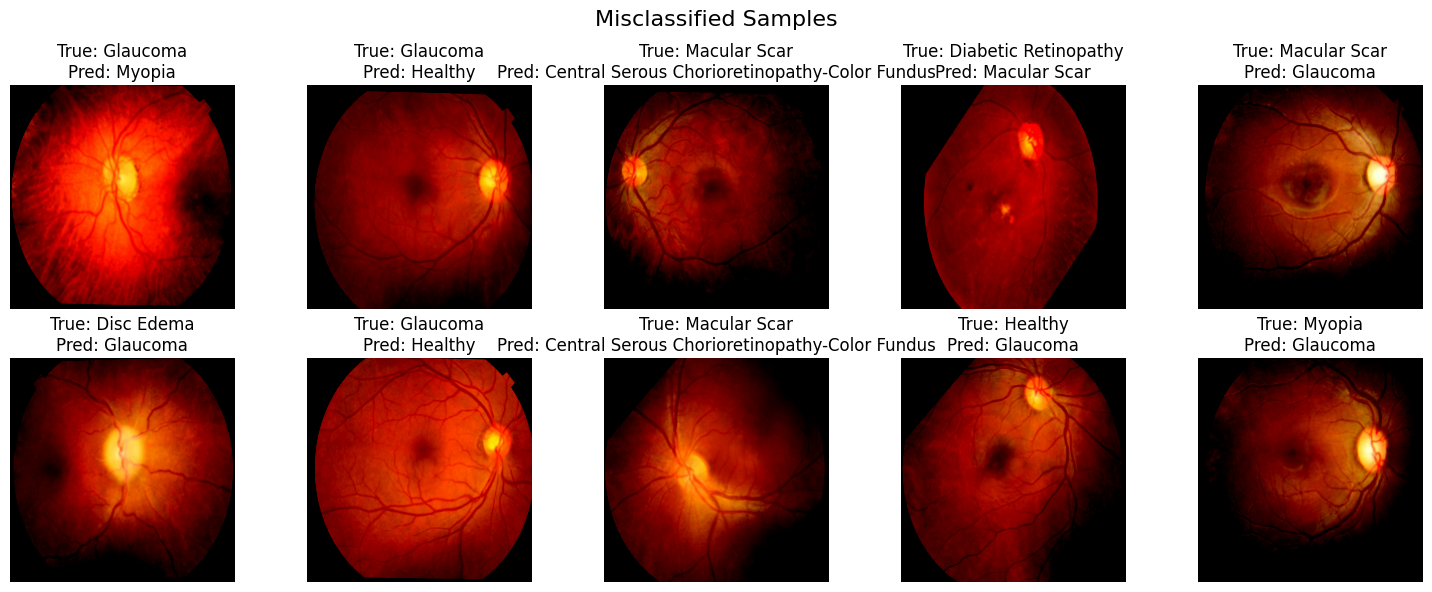

In [55]:
plot_misclassified_samples(test_misclassified_samples)